In [1]:
#read dfs# import packages
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [2]:
quan_train_x=pd.read_csv("../input/garanti-mustafa/quan_train_x.csv")
quan_train_y=pd.read_csv("../input/garanti-mustafa/quan_train_y.csv")
quan_test=pd.read_csv("../input/garanti-mustafa/quan_test.csv")

label_enc_train_x=pd.read_csv("../input/garanti-mustafa/label_enc_train_x.csv")
label_enc_train_y=pd.read_csv("../input/garanti-mustafa/label_enc_train_y.csv")
label_enc_test=pd.read_csv("../input/garanti-mustafa/label_enc_test.csv")

onehot_train_x=pd.read_csv("../input/garanti-mustafa/onehot_train_x.csv")
onehot_train_y=pd.read_csv("../input/garanti-mustafa/onehot_train_y.csv")
onehot_test=pd.read_csv("../input/garanti-mustafa/onehot_test.csv")

onehot_df=pd.read_csv("../input/garanti-mustafa/onehot_df.csv")
quantile_df=pd.read_csv("../input/garanti-mustafa/quantile_df.csv")

In [3]:
# cross-validation with 5 splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

#Importing XGBM Classifier 
import xgboost as xgb

#creating an extreme Gradient boosting instance
xgb_model = xgb.XGBRegressor(
                   #early_stopping_rounds=100,
                   random_state=0, 
                   tree_method='gpu_hist', 
                   verbosity=0
                )

parameters = {'max_depth': list(range(4, 10)),
      'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
      'n_estimators': list(range(50, 1000)),
      'gamma': list(np.linspace(0, 1)),
      'min_child_weight': list(range(1, 50)),
      'max_delta_step': list(range(0, 10)),
      "max_leaves": list(range(10, 90)),
      'subsample': list(np.linspace(0.4, 1, 10)),
      'reg_alpha': list(np.linspace(0, 1)),
      'reg_lambda': list(np.linspace(0, 1)),
      'colsample_bytree' :list(np.linspace(0.4, 1, 10)),
      },


In [4]:
# grid search for parameters
grid = RandomizedSearchCV(estimator=xgb_model, param_distributions=parameters, cv=cv, n_iter=500)
grid.fit(onehot_train_x, onehot_train_y)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'subsample': 0.5333333333333333, 'reg_lambda': 0.7346938775510203, 'reg_alpha': 0.12244897959183673, 'n_estimators': 153, 'min_child_weight': 45, 'max_leaves': 20, 'max_depth': 5, 'max_delta_step': 0, 'learning_rate': 0.010897034921514772, 'gamma': 0.7346938775510203, 'colsample_bytree': 0.9333333333333333} with a score of 0.1458


In [5]:
# extend n_estimators to 1000
best_params_dict=grid.best_estimator_.get_params()
#best_params_dict["n_estimators"]=1000
extented_xgb = xgb.XGBRegressor().set_params(**best_params_dict)
extented_xgb.fit(onehot_train_x, onehot_train_y)

# prediction results
y_pred = extented_xgb.predict(onehot_test)

In [6]:
len(np.unique(y_pred))

7058

(array([1.4282e+04, 9.0200e+02, 4.9200e+02, 3.0500e+02, 1.9200e+02,
        1.1100e+02, 1.0800e+02, 9.2000e+01, 1.0900e+02, 1.0300e+02,
        7.4000e+01, 5.2000e+01, 3.4000e+01, 1.7000e+01, 1.3000e+01,
        9.0000e+00, 5.0000e+00, 9.0000e+00, 6.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.00

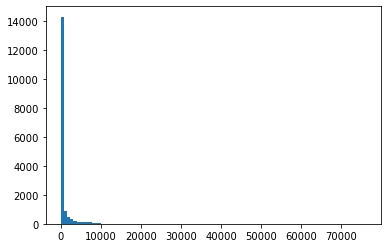

In [7]:
plt.hist(y_pred, bins=100)

In [8]:
np.sum(y_pred<=0)

0

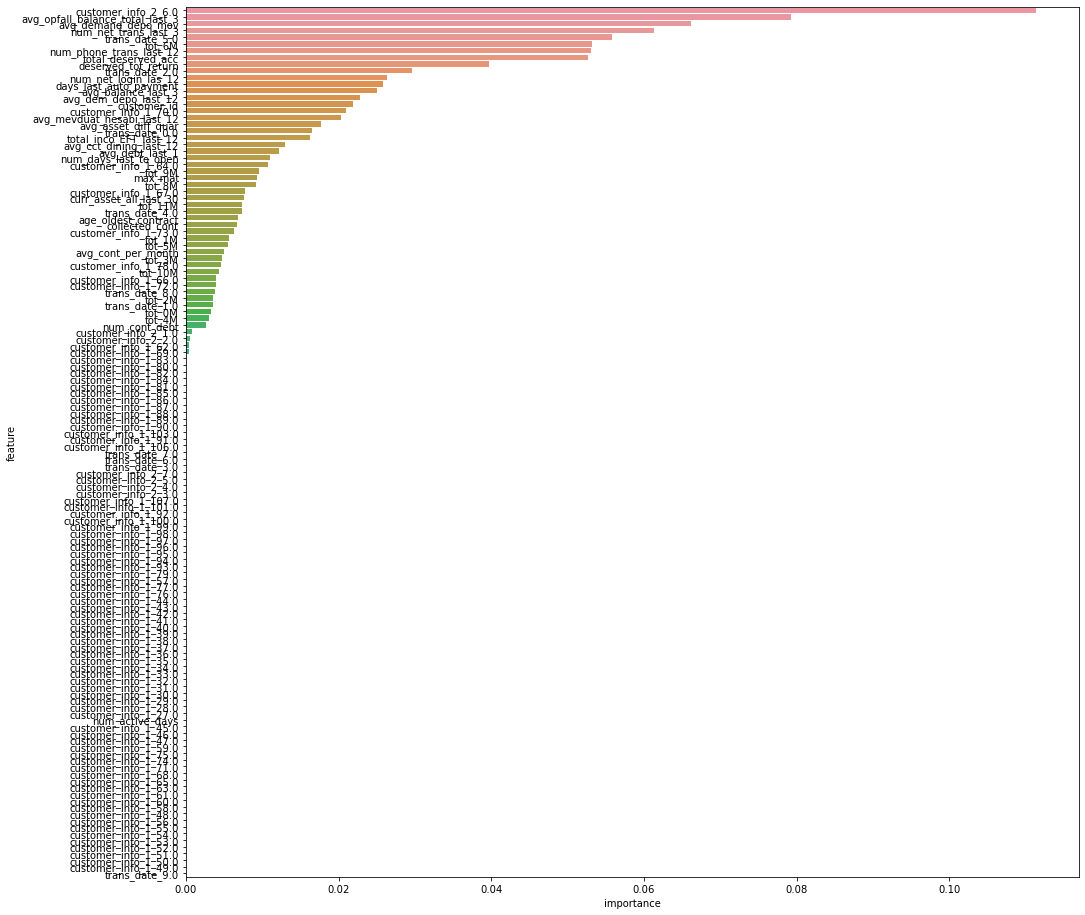

In [9]:
importance_df=pd.DataFrame(zip(onehot_test.columns.tolist(),extented_xgb.feature_importances_),columns=["feature","importance"])

import seaborn as sns
plt.figure(figsize=(16, 16))
sns.barplot(data=importance_df.sort_values(by='importance', ascending=False), x='importance', y='feature')

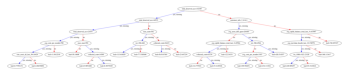

In [10]:
from xgboost import plot_tree
plot_tree(extented_xgb, num_trees=0)

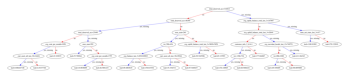

In [11]:
plot_tree(extented_xgb, num_trees=1)

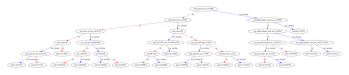

In [12]:
plot_tree(extented_xgb, num_trees=50)

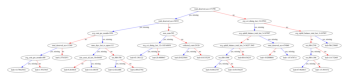

In [13]:
plot_tree(extented_xgb, num_trees=100)

# PREDICTION w CV

In [14]:
from sklearn.metrics import mean_squared_error
import gc
import math

# https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def train_model(data_, test_, y_, folds_, best_params_dict):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])

    feature_importance_df = pd.DataFrame()

    feats = test_.columns.tolist()

    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_, y_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]

        # parameters found by Bayesian optimization
        clf = xgb.XGBRegressor()
        clf.set_params(**best_params_dict)

        clf.fit(
            trn_x,
            trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='rmse',
            early_stopping_rounds=100  #30
        )

        oof_preds[val_idx] = clf.predict(val_x)
        sub_preds += clf.predict(test_[feats]) / folds_.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print('Fold %2d RMSE : %.6f' %
              (n_fold + 1, math.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()

    print('Full RMSE score %.6f' % math.sqrt(mean_squared_error(y_, oof_preds)))

    df_sub_preds = pd.DataFrame({'customer_id':test_["customer_id"], 'PREDICTION':sub_preds})
    df_sub_preds = df_sub_preds[['customer_id', 'PREDICTION']]
    
    df_oof_preds = pd.DataFrame({'customer_id':data_["customer_id"].values, 'TARGET':y_.iloc[:,0], 'PREDICTION':oof_preds})
    df_oof_preds = df_oof_preds[['customer_id', 'TARGET', 'PREDICTION']]

    return oof_preds, df_oof_preds, df_sub_preds, \
            feature_importance_df, math.sqrt(mean_squared_error(y_, oof_preds))

In [15]:
folds = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

oof_preds, df_oof_preds, test_preds, importances, score = \
    train_model(onehot_train_x, onehot_test, onehot_train_y, folds, best_params_dict)

[0]	validation_0-rmse:8127.04248	validation_1-rmse:7108.41992
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8116.02734	validation_1-rmse:7097.59375
[2]	validation_0-rmse:8100.98486	validation_1-rmse:7082.21728
[3]	validation_0-rmse:8087.61426	validation_1-rmse:7068.61230
[4]	validation_0-rmse:8076.64697	validation_1-rmse:7058.21484
[5]	validation_0-rmse:8064.70850	validation_1-rmse:7049.33545
[6]	validation_0-rmse:8054.29785	validation_1-rmse:7039.04346
[7]	validation_0-rmse:8043.50684	validation_1-rmse:7028.54395
[8]	validation_0-rmse:8035.25098	validation_1-rmse:7021.74658
[9]	validation_0-rmse:8027.52002	validation_1-rmse:7014.76514
[10]	validation_0-rmse:8019.69629	validation_1-rmse:7006.53125
[11]	validation_0-rmse:8010.65088	validation_1-rmse:6998.49219
[12]	validation_0-rmse:8001.59033	validation_1-rmse:6989.66504
[13]	validation_0-rmse:7992.271

In [16]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = importances[["feature", "importance"]].groupby(
        "feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index()

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=cols)
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgboost_importances-01.png')

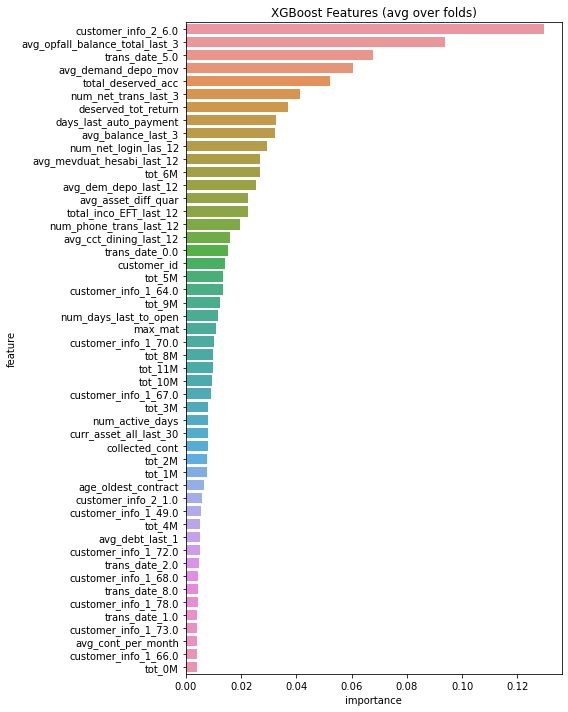

In [17]:
display_importances(feature_importance_df_=importances)

# SUBMISSIONS

In [18]:
# straight prediction results
submission_df=pd.DataFrame(zip(onehot_test["customer_id"],y_pred), columns=["Id", "Predicted"])
submission_df.to_csv('onehot_straight_random.csv', index=False)

In [19]:
# cv prediction results
submission_df2=pd.DataFrame(zip(test_preds["customer_id"],test_preds["PREDICTION"]), columns=["Id", "Predicted"])
submission_df2.to_csv('onehot_CV_random.csv', index=False)